# 01. Natural Language Processing with TensorFlow


The main goal of [natural language processing (NLP)](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32) is to derive information from natural language.

Natural language is a broad term but you can consider it to cover any of the following:
* Text (such as that contained in an email, blog post, book, Tweet)
* Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)




## What we're going to cover


* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-04-30 23:28:27.565630


In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4faf9cc6-3def-440e-8d14-16abc695b339)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script containing our helper functions can be [found on GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [3]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Download a text dataset

Let's start by download a text dataset. We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) dataset from Kaggle which contains text-based Tweets about natural disasters.


```


The original downloaded data has not been altered to how you would download it from Kaggle.


In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-04-30 23:31:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-04-30 23:31:42 (102 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

In [5]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data we downloaded is probably shuffled already. But just to be sure, let's shuffle it again.

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.


In [7]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's check how many examples of each target we have.

In [8]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where,

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

And what about the total number of samples we have?

In [9]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Alright, seems like we've got a decent amount of training and test data. If anything, we've got an abundance of testing examples, usually a split of 90/10 (90% training, 10% testing) or 80/20 is suffice.

Okay, time to visualize, let's write some code to visualize random text samples.



In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Armageddon averted by El Patron
#UltimaLucha

---

Target: 1 (real disaster)
Text:
Exploring New Worlds: Three Moments of an Explosion by China MiÌ©ville http://t.co/OTrwZ1t9sp http://t.co/xVlkFCvfX5

---

Target: 1 (real disaster)
Text:
Rocky fire in Northern California swells to 60000 acres; 12000 evacuated http://t.co/mtfnbhRYZq Portland #Phoenix #Miami #Atlanta #Casper

---

Target: 0 (not real disaster)
Text:
@DaneMillar1 *screams 666*

---

Target: 1 (real disaster)
Text:
Warne shocked over Australia's epic collapse at Trent Bridge: Johannesburg Aug 06 (ANI): Legendary Australian... http://t.co/LwwoJXtTIV

---



### Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method and dedicate 10% of the training samples to the validation set.

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers



Our labels are in numerical form (`0` and `1`) but our Tweets are in string form.


In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
  1. **Create our own embedding** - Once our text has been turned into numbers (required for an embedding), we can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.




### Text vectorization (tokenization)

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

Let's see it in action.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [15]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Now let's create another `TextVectorization` object using our custom parameters.

In [16]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Training data mapped! Let's try our `text_vectorizer` on a custom sentence (one similar to what you might see in the training data).

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

How about we try our `text_vectorizer` on a few random sentences?

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@LA_Siren Thanks for joining the foot. @VVorm      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  565,   10, 3716,    2, 3837, 6960,    0,    0,    0,    0,
           0,    0,    0,    0]])>

we can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer



The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.


The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

Excellent, notice how `embedding` is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.


In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Maryland mansion fire that killed 6 caused by damaged plug under Christmas tree report says - Into the flames... http://t.co/ucUDwIU3aN      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 1.6084425e-03,  4.1912768e-02, -2.1471882e-02, ...,
         -2.5243536e-03, -3.8631260e-06, -2.9487301e-02],
        [ 1.8078003e-02,  1.5223656e-02, -3.3829436e-03, ...,
         -2.3568107e-02,  2.8246347e-02, -3.7283599e-02],
        [ 4.4378582e-02, -3.8148843e-02,  1.3007466e-02, ...,
         -3.8423598e-02, -4.5318831e-02,  8.2634464e-03],
        ...,
        [ 2.5265243e-02, -2.3114085e-02, -1.6448520e-02, ...,
         -3.1279765e-02, -1.1906695e-02,  2.4286259e-02],
        [ 4.5905355e-02, -2.8394008e-02, -3.2320321e-02, ...,
          3.2342557e-02,  4.5224618e-02, -4.2996373e-02],
        [ 3.6113229e-02,  3.7493933e-02, -1.5098229e-03, ...,
         -2.7854456e-02, -2.9738462e-02, -3.1154348e-02]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 1.60844252e-03,  4.19127680e-02, -2.14718822e-02,  4.12443168e-02,
        4.71856333e-02, -3.76453511e-02, -4.51670066e-02,  1.45447887e-02,
       -4.80553173e-02, -3.14194188e-02,  3.03230025e-02, -1.53891072e-02,
        8.82804394e-04, -3.71318832e-02, -4.31103371e-02, -4.11014631e-03,
       -4.63781953e-02,  1.42317303e-02, -3.86580005e-02, -2.78753396e-02,
       -8.40884447e-03,  3.68380658e-02, -3.82612720e-02, -2.74412706e-03,
        1.08368769e-02, -2.89695151e-02, -4.52397354e-02,  3.83428670e-02,
       -3.90165336e-02, -3.90052572e-02,  3.95316146e-02, -3.32378373e-02,
       -4.64625470e-02,  4.54616547e-03,  3.46807390e-03,  6.51769713e-03,
       -1.19229928e-02, -2.19399091e-02, -8.43100622e-03,  1.08691677e-02,
        1.52129866e-02, -3.30861807e-02,  2.03399770e-02,  4.22571637e-02,
       -2.32409593e-02,  3.21697854e-02, -4.57970500e-02,  2.46719271e-03,
       -4.19716127e-02,  1.38353221e-02, -1.90191623

## Modelling a text dataset

we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

Let's get started.

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

Let's evaluate our model and find our baseline metric.

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


How about we make some predictions with our baseline model?

In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score


In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer.

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.



And since we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from `helper_functions.py` to keep track of the results of each.

In [30]:
# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

Now we've got a TensorBoard callback function ready to go, let's build our first deep model.

In [31]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [32]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Model compiled. Let's get a summary.

In [33]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

Most of the trainable parameters are contained within the embedding layer. Recall we created an embedding of size 128 (`output_dim=128`) for a vocabulary of size 10,000 (`input_dim=10000`), hence the 1,280,000 trainable parameters.

Alright, our model is compiled, let's fit it to our training data for 5 epochs. We'll also pass our TensorBoard callback function to make sure our model's training metrics are logged.

In [34]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240430-234549
Epoch 1/5
215/215 [==============================] - 17s 68ms/step - loss: 0.6100 - accuracy: 0.6911 - val_loss: 0.5363 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4417 - accuracy: 0.8192 - val_loss: 0.4692 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3468 - accuracy: 0.8606 - val_loss: 0.4590 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2851 - accuracy: 0.8918 - val_loss: 0.4640 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2382 - accuracy: 0.9120 - val_loss: 0.4766 - val_accuracy: 0.7861


Nice! Since we're using such a simple model, each epoch processes very quickly.

Let's check our model's performance on the validation set.

In [35]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7861


[0.4765856862068176, 0.7860892415046692]

In [36]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.06261235,  0.04479365, -0.01942671, ...,  0.03244354,
          0.03787545,  0.04266874],
        [ 0.03167142,  0.03858844,  0.01648138, ..., -0.00485165,
          0.02816375,  0.03217447],
        [-0.00889744,  0.0714072 , -0.03050258, ..., -0.03150315,
          0.02733545, -0.02446837],
        ...,
        [-0.04064487,  0.02652148, -0.01520817, ..., -0.00956736,
          0.0125117 , -0.04882004],
        [-0.02391225,  0.08450831, -0.00952621, ..., -0.03109108,
         -0.00666075,  0.06771915],
        [-0.11333721,  0.10840459, -0.01966752, ..., -0.04485768,
          0.04039136,  0.03244801]], dtype=float32)>]

In [37]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [38]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 3ms/step


array([[0.4100298 ],
       [0.7443642 ],
       [0.9978072 ],
       [0.11269005],
       [0.10360616],
       [0.9305561 ],
       [0.9109133 ],
       [0.992897  ],
       [0.96727455],
       [0.2698748 ]], dtype=float32)



The output threshold of a sigmoid prediction probability doesn't necessarily have to 0.5. For example, through testing, you may find that a cut off of 0.25 is better for your chosen evaluation metrics. A common example of this threshold cutoff is the [precision-recall tradeoff](https://en.wikipedia.org/wiki/Precision_and_recall#Introduction) (search for the keyword "tradeoff" to learn about the phenomenon).

In [39]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Now we've got our model's predictions in the form of classes, we can use our `calculate_results()` function to compare them to the ground truth validation labels.

In [40]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

How about we compare our first deep model to our baseline model?

In [41]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Since we'll be doing this kind of comparison (baseline compared to new model) quite a few times, let's create a function to help us out.

In [42]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

To do so, let's remind ourselves of the words in our vocabulary.


In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

And now let's get our embedding layer's weights (these are the numerical representations of each word).

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [45]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding.

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).



In [ ]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

## Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.



When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).



### Model 2: LSTM


We're going to start with an LSTM-powered RNN.


Our model is going to take on a very similar structure to `model_1`:


The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [46]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)




Now we've got our LSTM model built, let's compile it using `"binary_crossentropy"` loss and the Adam optimizer.

In [47]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

And before we fit our model to the data, let's get a summary.

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Looking good! You'll notice a fair few more trainable parameters within our LSTM layer than `model_1`.



Now our first RNN model's compiled let's fit it to our training data, validating it on the validation data and tracking its training parameters using our TensorBoard callback.

In [49]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240430-235419
Epoch 1/5
215/215 [==============================] - 10s 32ms/step - loss: 0.5116 - accuracy: 0.7402 - val_loss: 0.4548 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3168 - accuracy: 0.8716 - val_loss: 0.5123 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2193 - accuracy: 0.9162 - val_loss: 0.5918 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1545 - accuracy: 0.9463 - val_loss: 0.6220 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1101 - accuracy: 0.9602 - val_loss: 0.7855 - val_accuracy: 0.7598


Nice! We've got our first trained RNN model using LSTM cells. Let's make some predictions with it.

The same thing will happen as before, due to the sigmoid activiation function in the final layer, when we call the `predict()` method on our model, it'll return prediction probabilities rather than classes.

In [50]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 2s 9ms/step


((762, 1),
 array([[0.0436953 ],
        [0.7976073 ],
        [0.99856853],
        [0.07788213],
        [0.00559476],
        [0.99869424],
        [0.9731496 ],
        [0.9995228 ],
        [0.99922943],
        [0.27669612]], dtype=float32))

We can turn these prediction probabilities into prediction classes by rounding to the nearest integer (by default, prediction probabilities under 0.5 will go to 0 and those over 0.5 will go to 1).

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Beautiful, now let's use our `caculate_results()` function to evaluate our LSTM model and our `compare_baseline_to_new_results()` function to compare it to our baseline model.

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.98425196850394,
 'precision': 0.7599947657549518,
 'recall': 0.7598425196850394,
 'f1': 0.7584680708642795}

In [53]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.98, Difference: -3.28
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.


To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [54]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

TensorFlow makes it easy to use powerful components such as the GRU cell in our models. And now our third model is built, let's compile it, just as before.

In [55]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

What does a summary of our model look like?

In [56]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

We'll fit our model just as we've been doing previously. We'll also track our models results using our `create_tensorboard_callback()` function.

In [57]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240430-235706
Epoch 1/5
215/215 [==============================] - 13s 49ms/step - loss: 0.5294 - accuracy: 0.7238 - val_loss: 0.4552 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3211 - accuracy: 0.8678 - val_loss: 0.4871 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2204 - accuracy: 0.9159 - val_loss: 0.5536 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1586 - accuracy: 0.9453 - val_loss: 0.6148 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1201 - accuracy: 0.9594 - val_loss: 0.6172 - val_accuracy: 0.7756


Due to the optimized default settings of the GRU cell in TensorFlow, training doesn't take long at all.

Time to make some predictions on the validation samples.

In [58]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


((762, 1),
 array([[0.34902948],
        [0.88375044],
        [0.9966965 ],
        [0.13344474],
        [0.01109472],
        [0.9914226 ],
        [0.6766315 ],
        [0.99789727],
        [0.99694   ],
        [0.62554   ]], dtype=float32))

Again we get an array of prediction probabilities back which we can convert to prediction classes by rounding them.

In [59]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Now we've got predicted classes, let's evaluate them against the ground truth labels.

In [60]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.55905511811024,
 'precision': 0.7755973093483475,
 'recall': 0.7755905511811023,
 'f1': 0.7746054164754071}

Finally we can compare our GRU model's results to our baseline.

In [61]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.56, Difference: -1.71
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


### Model 4: Bidirectonal RNN model

Look at us go! We've already built two RNN's with GRU and LSTM cells. Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.



In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).


In [62]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

> 🔑 **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

Our bidirectional model is built, let's compile it.

In [63]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

And of course, we'll check out a summary.

In [64]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

Notice the increased number of trainable parameters in `model_4` (bidirectional LSTM) compared to `model_2` (regular LSTM). This is due to the bidirectionality we added to our RNN.

Time to fit our bidirectional model and track its performance.

In [65]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240430-235818
Epoch 1/5
215/215 [==============================] - 12s 40ms/step - loss: 0.5079 - accuracy: 0.7478 - val_loss: 0.4596 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3126 - accuracy: 0.8723 - val_loss: 0.5268 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2115 - accuracy: 0.9177 - val_loss: 0.5664 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1441 - accuracy: 0.9512 - val_loss: 0.6738 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1030 - accuracy: 0.9623 - val_loss: 0.7236 - val_accuracy: 0.7625


In [66]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.01421876],
       [0.8469897 ],
       [0.99930906],
       [0.13661829],
       [0.00298985],
       [0.99604416],
       [0.8937946 ],
       [0.99957055],
       [0.9994572 ],
       [0.27714416]], dtype=float32)

And we'll convert them to prediction classes and evaluate them against the ground truth labels and baseline model.

In [67]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [68]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 0.7625326572242482,
 'recall': 0.7624671916010499,
 'f1': 0.7612168110136286}

In [69]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Convolutional Neural Networks for Text


The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```



The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

The state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

>


### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a **temporal convolution**) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [71]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (`input_length=15` and `output_dim=128`).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

Let's take a peak at what each of these transformations looks like.

In [72]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.0182307 ,  0.0006638 , -0.01411113, ..., -0.04671139,
           0.04754145, -0.00910726],
         [-0.02202228,  0.04994492, -0.05394889, ..., -0.04672154,
           0.04220126,  0.00113612],
         [-0.0443279 ,  0.04316662, -0.03796913, ...,  0.00746332,
           0.03628081,  0.03462908],
         ...,
         [-0.06261235,  0.04479365, -0.01942671, ...,  0.03244354,
           0.03787545,  0.04266874],
         [-0.06261235,  0.04479365, -0.01942671, ...,  0.03244354,
           0.03787545,  0.04266874],
         [-0.06261235,  0.04479365, -0.01942671, ...,  0.03244354,
           0.03787545,  0.04266874]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[1.41091191e-03, 6.79019094e-02, 0.00000000e+00, 1.11556590e-01,
          9.65866297e-02, 1.01773545e-01, 2.50620246e-02, 1.19947828e-02,
          0.00000000e+00, 0.00000000e+00, 1.17113721e-02, 0.00000000e+00,
          7.

Alright, we've seen the outputs of several components of a CNN for sequences, let's put them together and construct a full model, compile it (just as we've done with our other models) and get a summary.

In [73]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

The number of trainable parameters for the 1-dimensional convolutional layer is similar to that of the LSTM layer in `model_2`.

Let's fit our 1D CNN model to our text data. In line with previous experiments, we'll save its results using our `create_tensorboard_callback()` function.

In [74]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240501-000126
Epoch 1/5
215/215 [==============================] - 11s 41ms/step - loss: 0.5641 - accuracy: 0.7176 - val_loss: 0.4719 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3408 - accuracy: 0.8616 - val_loss: 0.4692 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2142 - accuracy: 0.9216 - val_loss: 0.5297 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1403 - accuracy: 0.9536 - val_loss: 0.6045 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0973 - accuracy: 0.9670 - val_loss: 0.6588 - val_accuracy: 0.7835


Nice! Thanks to GPU acceleration, our 1D convolutional model trains nice and fast. Let's make some predictions with it and evaluate them just as before.

In [75]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.18870246],
       [0.73853964],
       [0.999818  ],
       [0.03833732],
       [0.00284664],
       [0.99509686],
       [0.9537875 ],
       [0.9980868 ],
       [0.99858594],
       [0.20349102]], dtype=float32)

In [76]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [77]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.34645669291339,
 'precision': 0.7868445599717488,
 'recall': 0.7834645669291339,
 'f1': 0.7809185675137833}

In [78]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.35, Difference: -0.92
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.





### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.


> 🔑 **Note:** An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.

As usual, this is best demonstrated with an example.

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [83]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When we call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [84]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [81]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

Beautiful! Now we've got the USE as a Keras layer, we can use it in a Keras Sequential model.

In [82]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the [Universal Sentence Encoder paper](https://www.aclweb.org/anthology/D18-2029.pdf) for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting `trainable=True` when creating the `hub.KerasLayer` instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our `create_tensorboard_callback()` function.

In [85]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240501-000448
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5006 - accuracy: 0.7914 - val_loss: 0.4476 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4142 - accuracy: 0.8152 - val_loss: 0.4368 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3996 - accuracy: 0.8219 - val_loss: 0.4329 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3924 - accuracy: 0.8269 - val_loss: 0.4284 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3862 - accuracy: 0.8291 - val_loss: 0.4299 - val_accuracy: 0.8123


USE model trained! Let's make some predictions with it an evaluate them as we've done with our other models.

In [86]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.15870029],
       [0.74847883],
       [0.9874362 ],
       [0.20080213],
       [0.72014546],
       [0.68733597],
       [0.9801869 ],
       [0.97552073],
       [0.9225749 ],
       [0.08774451]], dtype=float32)

In [87]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [89]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [90]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ###

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [91]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [92]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


Because we've selected a random subset of the training samples, the classes should be roughly balanced (as they are in the full training dataset).

In [93]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (`model_6`) using the [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [94]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Notice the layout of `model_7` is the same as `model_6`. Now let's train the newly created model on our 10% training data subset.

In [95]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240501-000534
Epoch 1/5
22/22 [==============================] - 3s 46ms/step - loss: 0.6694 - accuracy: 0.6997 - val_loss: 0.6542 - val_accuracy: 0.6929
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6011 - accuracy: 0.7901 - val_loss: 0.5990 - val_accuracy: 0.7323
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5244 - accuracy: 0.8163 - val_loss: 0.5440 - val_accuracy: 0.7677
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4584 - accuracy: 0.8382 - val_loss: 0.5097 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4137 - accuracy: 0.8397 - val_loss: 0.4918 - val_accuracy: 0.7730


Due to the smaller amount of training data, training happens even quicker than before.

Let's evaluate our model's performance after learning on 10% of the training data.

In [96]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.2662866 ],
       [0.7724195 ],
       [0.89539325],
       [0.3216646 ],
       [0.57601786],
       [0.83050483],
       [0.8054859 ],
       [0.8416127 ],
       [0.83741456],
       [0.14180054]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.29658792650919,
 'precision': 0.777881100544101,
 'recall': 0.7729658792650919,
 'f1': 0.7695350827050221}

In [99]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Comparing the performance of each of our models

Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for `model_7` where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [100]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.984252,0.759995,0.759843,0.758468
gru,77.559055,0.775597,0.775591,0.774605
bidirectional,76.246719,0.762533,0.762467,0.761217
conv1d,78.346457,0.786845,0.783465,0.780919
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.296588,0.777881,0.772966,0.769535


In [101]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

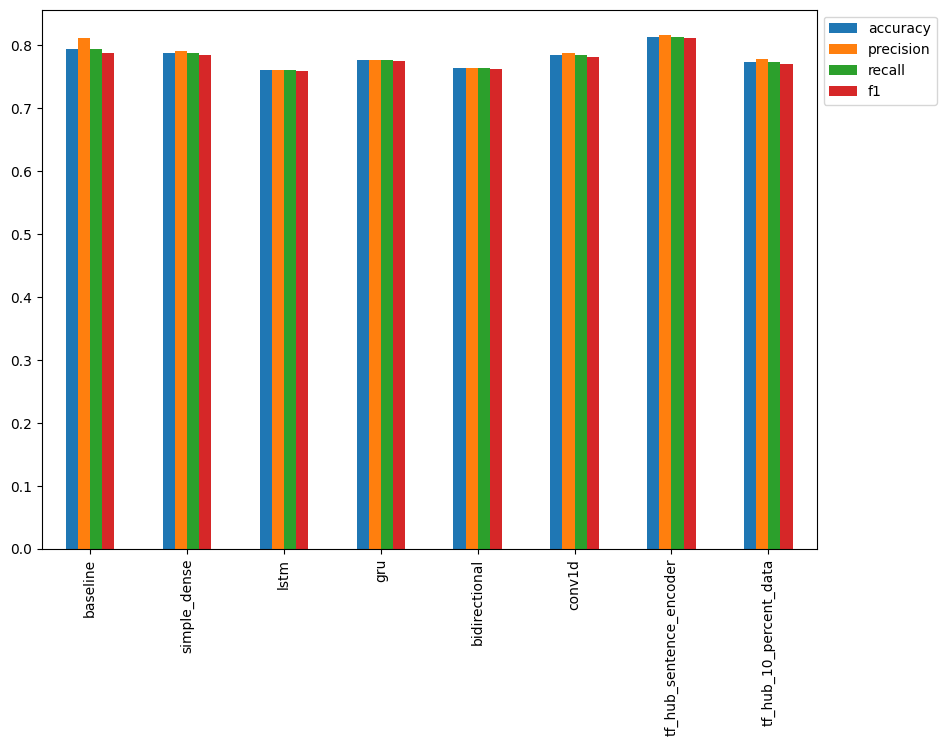

In [102]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Looks like our pretrained USE TensorFlow Hub models have the best performance, even the one with only 10% of the training data seems to outperform the other models. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

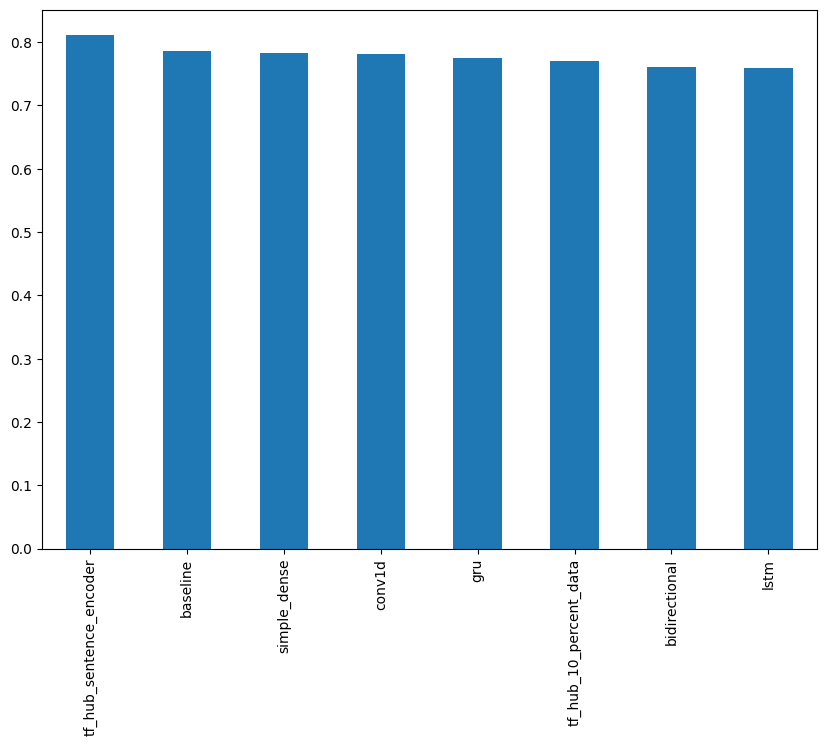

In [103]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Drilling down into a single metric we see our USE TensorFlow Hub models performing  better than all of the other models. Interestingly, the baseline's F1-score isn't too far off the rest of the deeper models.

We can also visualize all of our model's training logs using TensorBoard.dev.

In [104]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

## Combining our models (model ensembling/stacking)

Many production systems use an **ensemble** (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is **uncorrelated**, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.


Since we're working with a classification problem, there are a few of ways we can combine our models:
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)** - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict `[1, 0, 1]` respectively, the majority class is `1`, therefore, that would be the predicted label.
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.


Again, the concept of model stacking is best seen in action.

We're going to combine our baseline model (`model_0`), LSTM model (`model_2`) and our USE model trained on the full training data (`model_6`) by averaging the combined prediction probabilities of each.

In [106]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

We've got a combined predictions array of different classes, let's evaluate them against the true labels and add our stacked model's results to our `all_model_results` DataFrame.

In [107]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'precision': 0.7805831064048222,
 'recall': 0.7808398950131233,
 'f1': 0.7806452350205135}

In [108]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [109]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

<ipython-input-109-eb0b96b5da6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [110]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.759843,0.759995,0.759843,0.758468
gru,0.775591,0.775597,0.775591,0.774605
bidirectional,0.762467,0.762533,0.762467,0.761217
conv1d,0.783465,0.786845,0.783465,0.780919
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
tf_hub_10_percent_data,0.772966,0.777881,0.772966,0.769535
ensemble_results,78.083990,0.780583,0.780840,0.780645


How did the stacked model go against the other models?

> 🔑 **Note:** It seems many of our model's results are similar. This may mean there are some limitations to what can be learned from our data. When many of your modelling experiments return similar results, it's a good idea to revisit your data, we'll do this shortly.

## Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format.
2. The `SavedModel` format (default).

Let's take a look at both.

In [111]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


If you save a model as a `HDF5`, when loading it back in, you need to let [TensorFlow know about any custom objects you've used](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [112]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [113]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4299 - accuracy: 0.8123


[0.4299291968345642, 0.8123359680175781]

Calling the `save()` method on our target model and passing it a filepath allows us to save our model in the `SavedModel` format.

In [114]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

If you use SavedModel format (default), you can reload your model without specifying custom objects using the [`tensorflow.keras.models.load_model()`](https://www.tensorflow.org/tutorials/keras/save_and_load) function.

In [115]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [116]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4299 - accuracy: 0.8123


[0.4299292266368866, 0.8123359680175781]

If we need a more general-purpose data standard, `HDF5` might be better. For more, check out the [TensorFlow documentation on saving and loading models](https://www.tensorflow.org/tutorials/keras/save_and_load).

## Finding the most wrong examples

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort our model's predictions and find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong?
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [117]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.158700
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.748479
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987436
3,@camilacabello97 Internally and externally scr...,1,0.0,0.200802
4,Radiation emergency #preparedness starts with ...,1,1.0,0.720145


Oh yeah! Now let's find our model's wrong predictions (where `target != pred`) and sort them by their prediction probability (the `pred_prob` column).

In [118]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.915311
759,FedEx will no longer transport bioterror patho...,0,1.0,0.859078
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.857376
628,@noah_anyname That's where the concentration c...,0,1.0,0.838902
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.836873
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.819604
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.781033
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.777842
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.773118
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.750050


Finally, we can write some code to visualize the sample text, truth label, prediction class and prediction probability. Because we've sorted our samples by prediction probability, viewing samples from the head of our `most_wrong` DataFrame will show us false positives.

A reminder:
* `0` = Not a real diaster Tweet
* `1` = Real diaster Tweet

In [119]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9153106808662415
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8590782880783081
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.857375979423523
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8389020562171936
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8368728160858154
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.819604218006134
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob

We can view the bottom end of our `most_wrong` DataFrame to inspect false negatives (model predicts 0, not a real diaster Tweet, when it should've predicted 1, real diaster Tweet).

In [120]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06137964501976967
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.06114107370376587
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.05666232481598854
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.05295721814036369
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.051580801606178284
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.043136194348335266
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03919411078095436
Te

## Making predictions on the test dataset

Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [121]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 63ms/step
Pred: 0, Prob: 0.34616029262542725
Text:
RT EmekaGift: VPSay NO to President Obama hosting Muhammadu Buhari the #pedophile #terrorist &amp; #mass-murderer

----

1/1 [==============================] - 0s 59ms/step
Pred: 0, Prob: 0.08036500960588455
Text:
Has the kids' bedtime gotten later &amp; later? Now's a good time to point out to them when their regular curfew would be. #BTSPrep #Parenting

----

1/1 [==============================] - 0s 58ms/step
Pred: 1, Prob: 0.8419773578643799
Text:
You know it's hot when there are bush fires right near your villa ????

----

1/1 [==============================] - 0s 58ms/step
Pred: 0, Prob: 0.05264878273010254
Text:
Can you imagine how traumatised Makoto would be if he could see himself in the dub (aka Jersey Shore AU) rn? Well done America

----

1/1 [==============================] - 0s 59ms/step
Pred: 1, Prob: 0.9465028643608093
Text:
#GRupdates Pic of 16yr old PKK suicide bomber who deto

How do our model's predictions look on the test dataset?

It's important to do these kind of visualization checks as often as possible to get a glance of how your model performs on unseen data and subsequently how it might perform on the real test: Tweets from the wild.

## Predicting on Tweets from the wild

How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

To start, let's take one of my own [Tweets on living life like an ensemble model](https://twitter.com/mrdbourke/status/1313649328351662082).

In [122]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

Now we'll write a small function to take a model and an example sentence and return a prediction.

In [124]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [125]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 35ms/step
Pred: 0.0 (not real disaster) Prob: 0.043352674692869186
Text:
Life like an ensemble: take the best choices from others and make your own


 Our model predicted correctly. My Tweet wasn't about a diaster.

How about we find a few Tweets about actual diasters?



In [126]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [127]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 37ms/step
Pred: 1.0 (real disaster) Prob: 0.9616581797599792
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [128]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 35ms/step
Pred: 1.0 (real disaster) Prob: 0.9712861180305481
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


Looks like our model is performing as expected, predicting both of the diaster Tweets as actual diasters.

> 🔑 **Note:** The above examples are cherry-picked and are cases where you'd expect a model to function at high performance. For actual production systems, you'll want to continaully perform tests to see how your model is performing.

In [129]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

Looking good!

Now let's use our `pred_timer()` function to evaluate the prediction times of our best performing model (`model_6`) and our baseline model (`model_0`).

In [130]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 9ms/step


(0.2938509499999782, 0.000385631167978974)

In [131]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02078744700020252, 2.7280114173494118e-05)

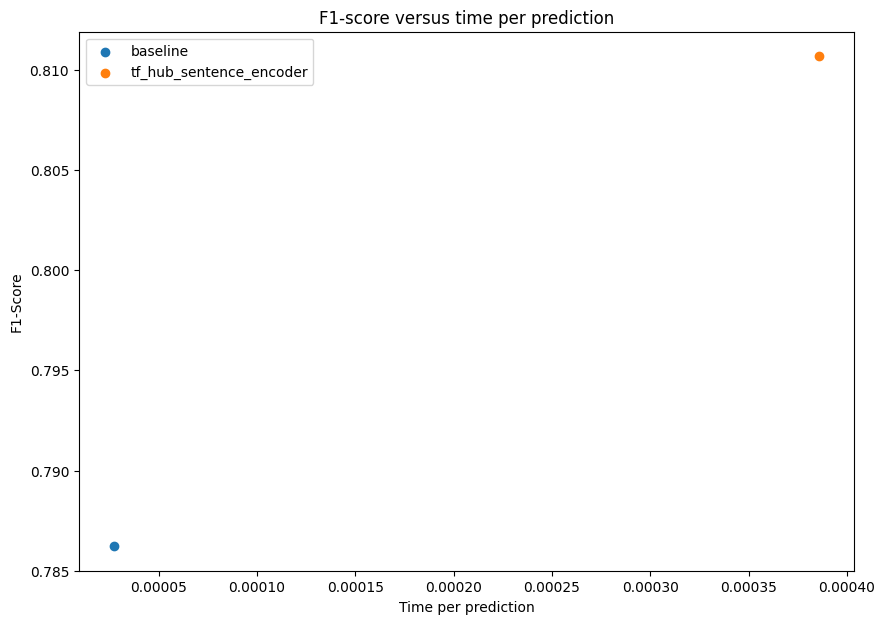

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");



Of course, the ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score).

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.
